# RNN based Predictions

1. This Note is Similar to 'BitKube.ipynb' but it was used for RNN models Hyper Paramter Tuning
2. It can be considered as rough or parallel working

In [1]:
# Importing required libraries and setting the directory path

import tensorflow as tf
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import model_from_json
import datetime
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
#from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import Callback
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

%matplotlib inline

#folder_path = os.path.join(os.getcwd(), 'datasets/bitbrains/fastStorage/2013-8/')
july = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-7/')
august = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-8/')
septempber = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-9/')

2024-07-27 20:31:23.731535: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 20:31:23.956709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 20:31:23.956874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 20:31:23.983370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 20:31:24.044284: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')

    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    return df

df2_july = pd.read_csv(os.path.join(july, '383.csv'), sep=';')
df2_aug = pd.read_csv(os.path.join(august, '383.csv'), sep=';')
df2_sep = pd.read_csv(os.path.join(septempber, '383.csv'), sep=';')

df4_july = pd.read_csv(os.path.join(july, '392.csv'), sep=';')
df4_aug = pd.read_csv(os.path.join(august, '392.csv'), sep=';')
df4_sep = pd.read_csv(os.path.join(septempber, '392.csv'), sep=';')

df6_july = pd.read_csv(os.path.join(july, '386.csv'), sep=';')
df6_aug = pd.read_csv(os.path.join(august, '386.csv'), sep=';')
df6_sep = pd.read_csv(os.path.join(septempber, '386.csv'), sep=';')

dfs2_list = [df2_july, df2_aug, df2_sep]
dfs4_list = [df4_july, df4_aug, df4_sep]
dfs6_list = [df6_july, df6_aug, df6_sep]

dfs2 = [df_processing(df) for df in dfs2_list]
dfs4 = [df_processing(df) for df in dfs4_list]
dfs6 = [df_processing(df) for df in dfs6_list]

df2 = pd.concat(dfs2)
df2 = df2.bfill()
df4 = pd.concat(dfs4)
df4 = df4.bfill()
df6 = pd.concat(dfs6)
df6 = df6.bfill()


In [3]:
def fill_missing(df, start, end):
    df.reset_index(inplace=True)

    # Identify the previous day's period for replication
    previous_day_start = start - pd.DateOffset(days=1)
    previous_day_end = end - pd.DateOffset(days=1)

    # Filter the DataFrame to get the previous day's data
    previous_day_data = df[(df['DateTime'] >= previous_day_start) & (df['DateTime'] <= previous_day_end)]

    # Generate new timestamps for the missing period
    missing_period_timestamps = pd.date_range(start=start, end=end, freq='5min')

    # Replicate the previous day's data to the missing period
    replicated_data = previous_day_data.copy()
    replicated_data['DateTime'] = missing_period_timestamps[:len(previous_day_data)]

    # Concatenate the replicated data with the original DataFrame
    df_filled = pd.concat([df, replicated_data]).sort_values(by='DateTime').reset_index(drop=True)
    df_filled.set_index('DateTime', inplace=True)

    return df_filled

start_july = pd.to_datetime('2013-07-30 23:00:00')
end_july = pd.to_datetime('2013-07-31 23:00:00')
start_aug = pd.to_datetime('2013-08-30 23:00:00')
end_aug = pd.to_datetime('2013-08-31 23:00:00')
df2 = fill_missing(df2, start_july, end_july)
df2 = fill_missing(df2, start_aug, end_aug)
df4 = fill_missing(df4, start_july, end_july)
df4 = fill_missing(df4, start_aug, end_aug)
df6 = fill_missing(df6, start_july, end_july)
df6 = fill_missing(df6, start_aug, end_aug)

df_list = [df2, df4, df6]
merged_df = pd.concat(df_list)

merged_df = merged_df.sort_index()
df = merged_df
df = df[['CPU cores', 'CPU usage [%]']]
df = df[df.index > '2013-06-30 23:55:00']
df.reset_index(inplace=True)
df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
#df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)
df.head(12)

,DateTime,CPU cores,CPU usage [%]
0,2013-07-01 00:00:00,2.0,17.300000
2,2013-07-01 00:00:00,4.0,9.983333
1,2013-07-01 00:00:00,6.0,40.777778
5,2013-07-01 00:05:00,2.0,20.600000
4,2013-07-01 00:05:00,4.0,27.833333
3,2013-07-01 00:05:00,6.0,41.311111
7,2013-07-01 00:10:00,2.0,17.566667
6,2013-07-01 00:10:00,4.0,50.433333
8,2013-07-01 00:10:00,6.0,37.333333
10,2013-07-01 00:15:00,2.0,18.233333


In [4]:
def feature_eng(df0):
    # Feature Engineering
    #df0['year'] = df0['DateTime'].dt.year
    df0['month'] = df0['DateTime'].dt.month
    df0['day'] = df0['DateTime'].dt.day
    df0['hour'] = df0['DateTime'].dt.hour
    df0['minute'] = df0['DateTime'].dt.minute
    df0['dayofweek'] = df0['DateTime'].dt.dayofweek
    df0.drop(columns=['DateTime'], inplace=True)
    return df0

df = feature_eng(df)
#df_synth = feature_eng(df_synth)

In [5]:
df.head()

,CPU cores,CPU usage [%],month,day,hour,minute,dayofweek
0,2.0,17.300000,7,1,0,0,0
2,4.0,9.983333,7,1,0,0,0
1,6.0,40.777778,7,1,0,0,0
5,2.0,20.600000,7,1,0,5,0
4,4.0,27.833333,7,1,0,5,0


In [6]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns[:-1]:
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
df_norm = normalize(df)
#df_synth_norm = normalize(df_synth)
df_norm.head()

,CPU cores,CPU usage [%],month,day,hour,minute,dayofweek
0,0.0,0.126083,0.0,0.0,0.0,0.000000,0.0
2,0.5,0.048859,0.0,0.0,0.0,0.000000,0.0
1,1.0,0.373880,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.160913,0.0,0.0,0.0,0.090909,0.0
4,0.5,0.237258,0.0,0.0,0.0,0.090909,0.0


In [7]:
# Multi Step Ahead Prediction

features = ['CPU cores', 'month', 'day', 'hour', 'minute', 'dayofweek', 'CPU usage [%]']
def create_sequences(data, seq_length=288, future_steps=6):
    df_as_numpy = data.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_numpy) - seq_length - future_steps):
        row = df_as_numpy[i:i+seq_length]  # Input sequence
        X.append(row)
        label = df_as_numpy[i+seq_length:i+seq_length+future_steps, -1]  # Future steps for CPU usage
        y.append(label)
    return np.array(X), np.array(y)

input_data = df_norm[features]

# Create sequences with the desired look-back and prediction horizons
seq_length = 144  # for instance, 24 time steps (e.g., 2 hours if each step is 5 minutes)
future_steps = 18  # predict 6 future steps (e.g., 30 minutes ahead)

X, y = create_sequences(input_data, seq_length, future_steps)

In [8]:
X.shape, y.shape

((78426, 144, 7), (78426, 18))

In [9]:
# X_train = X[:70731]
# X_test = X[70731:]
# y_train = y[:70731]
# y_test = y[70731:]
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70731, 288, 7), (70731, 18), (7551, 288, 7), (7551, 18))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
#X_val, , y_val,  = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70583, 144, 7), (70583, 18), (7843, 144, 7), (7843, 18))

# Hyper Parameter Tuning for LSTM

# LSTM Model

In [11]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(100, activation='relu', return_sequences=False))
lstm_model.add(Dense(future_steps, activation='linear'))  # Assuming y_train has shape (n_samples, n_features)
lstm_model.summary()

# bi_model = Sequential()
# bi_model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
# bi_model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False)))
# bi_model.add(Dense(future_steps, activation='linear'))  # Assuming y_train has shape (n_samples, n_features)
# bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 288, 100)          43200     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 125418 (489.91 KB)
Trainable params: 125418 (489.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
cp0 = ModelCheckpoint('models/lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [15]:
history = lstm_model.fit(X_train, y_train, 
                         validation_data=(X_val, y_val),
                         epochs=50, 
                         batch_size=64,
                         callbacks=[cp0, early_stopping])

Epoch 1/50
321/321 [==============================] - 91s 280ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147
Epoch 2/50
321/321 [==============================] - 91s 283ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 3/50
321/321 [==============================] - 86s 268ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 4/50
321/321 [==============================] - 85s 265ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 5/50
321/321 [==============================] - 88s 274ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 6/50
321/321 [==============================] - 86s 267ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_l

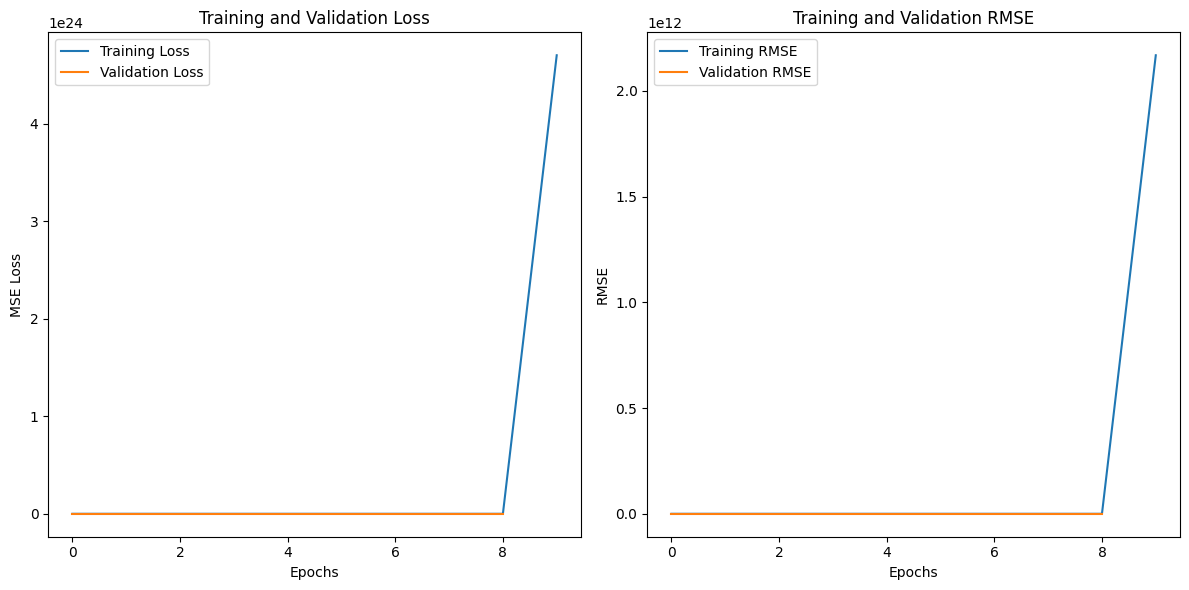

In [19]:
# Extract training and validation loss and RMSE from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot the training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(train_rmse[:-1], label='Training RMSE')
plt.plot(val_rmse[:-1], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

81/81 [==============================] - 6s 67ms/step


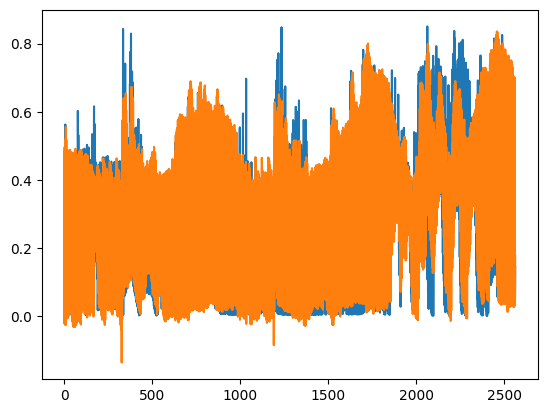

In [20]:
def plot_predictions(model, X, y, tstart=0, tend=100):
    predictions =  model.predict(X)
    c_pred = predictions[:, 0]
    c_pred = c_pred.reshape(-1)
    c_actuals = y[:, 0]
    test_results = pd.DataFrame(data={'CPU Predictions': c_pred, 
                              'CPU Actuals':c_actuals
                                    })
    
    plt.plot(test_results['CPU Actuals'][tstart:tend], label='Actual')
    plt.plot(test_results['CPU Predictions'][tstart:tend], label='Prediction')

    return test_results[tstart:tend]
result = plot_predictions(lstm_model, X_test, y_test, tstart=0, tend=3000)

In [21]:
c_max = df['CPU usage [%]'].max()
c_min = df['CPU usage [%]'].min()


def denormalize(df):
    result = df.copy()
    result['CPU Predictions'] = df['CPU Predictions'] * (c_max - c_min) + c_min
    result['CPU Actuals'] = df['CPU Actuals'] * (c_max - c_min) + c_min
    
    return result

df_cm_denorm = denormalize(result)
df_cm_denorm

,CPU Predictions,CPU Actuals
0,51.699833,47.533333
1,-1.937244,2.250000
2,36.423691,29.633333
3,53.004322,53.266667
4,-1.713740,2.250000
...,...,...
2557,3.533073,6.500000
2558,19.204765,14.733333
2559,74.897499,63.966667
2560,4.759590,6.533333


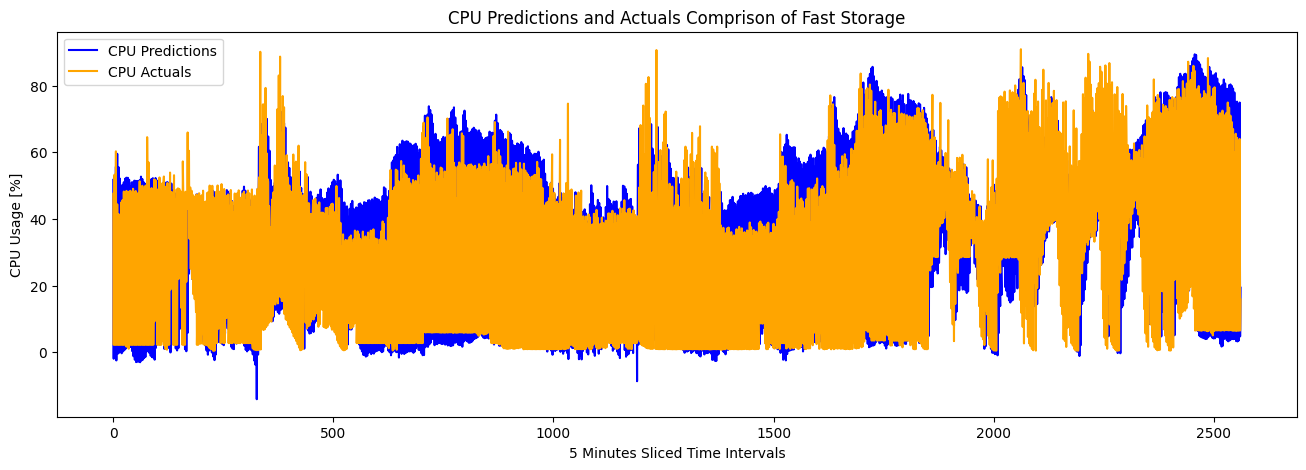

In [23]:
plt.figure(figsize=(16,5))
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Predictions'], label='CPU Predictions', color='blue')
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Actuals'], label='CPU Actuals', color='orange')

plt.xlabel('5 Minutes Sliced Time Intervals')
plt.ylabel('CPU Usage [%]')
plt.title('CPU Predictions and Actuals Comprison of Fast Storage')
plt.legend()

In [24]:
df_cm_denorm

,CPU Predictions,CPU Actuals
0,51.699833,47.533333
1,-1.937244,2.250000
2,36.423691,29.633333
3,53.004322,53.266667
4,-1.713740,2.250000
...,...,...
2557,3.533073,6.500000
2558,19.204765,14.733333
2559,74.897499,63.966667
2560,4.759590,6.533333


In [25]:
# Evaluate the model
mse = mean_squared_error(df_cm_denorm['CPU Predictions'], df_cm_denorm['CPU Actuals'])
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 8.520127501033892


In [25]:
lstm_model.save('model0/lstm_352600_trained.keras')

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
gru_model.add(GRU(128, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(128, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(8, activation='relu'))
gru_model.add(Dense(future_steps, activation='linear'))
gru_model.summary()


In [10]:
X_train.shape, y_train.shape

((20673, 72, 7), (20673, 6))

## Bi-LSTM Model

In [11]:
## Bi-LSTM 64 means 128 neurons => 64 forward and 64 backward. To make All three use same Neurons, we set it to 64

bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
bi_model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False)))
bi_model.add(Dense(future_steps, activation='linear'))  # Assuming y_train has shape (n_samples, n_features)
bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 72, 200)           86400     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 18)                3618      
                                                                 
Total params: 330818 (1.26 MB)
Trainable params: 330818 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:

#cp0 = ModelCheckpoint('model0/bilstm-proactive.keras', save_best_only=True)

cp0 = ModelCheckpoint('model0/bilstm_test_synth.keras', save_best_only=True, monitor='loss', mode='min')
bi_model.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss=MeanSquaredError(), 
                 metrics=[RootMeanSquaredError()])

In [14]:
X_train.shape, y_train.shape, X_test.shape

((24120, 72, 7), (24120, 18), (6030, 72, 7))

In [15]:
history_bi = bi_model.fit(X_train, y_train, 
                       epochs=100, 
                       batch_size=128, 
                       callbacks=[cp0])

Epoch 1/100
189/189 [==============================] - 30s 150ms/step - loss: 0.0286 - root_mean_squared_error: 0.1693
Epoch 2/100
189/189 [==============================] - 30s 159ms/step - loss: 0.0117 - root_mean_squared_error: 0.1084
Epoch 3/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0113 - root_mean_squared_error: 0.1061
Epoch 4/100
189/189 [==============================] - 31s 162ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050
Epoch 5/100
189/189 [==============================] - 31s 165ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042
Epoch 6/100
189/189 [==============================] - 38s 201ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033
Epoch 7/100
189/189 [==============================] - 37s 195ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015
Epoch 8/100
189/189 [==============================] - 34s 180ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 9/100
189/189 [===========================

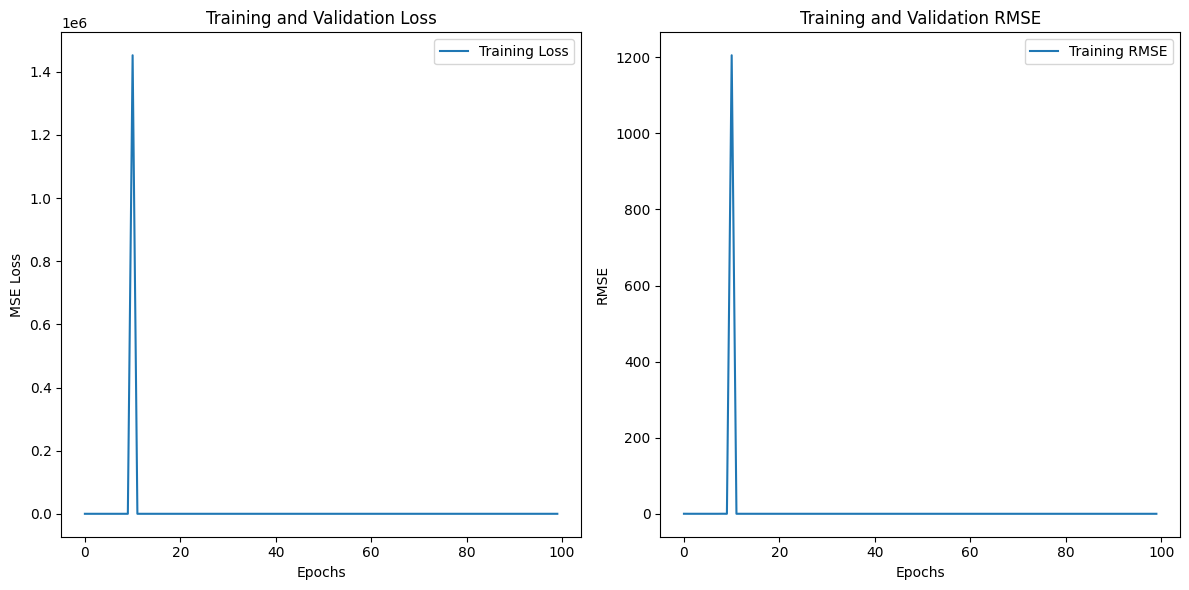

In [16]:
# Extract training and validation loss and RMSE from history
train_loss = history_bi.history['loss']
#val_loss = history_bi.history['val_loss']
train_rmse = history_bi.history['root_mean_squared_error']
#val_rmse = history_bi.history['val_root_mean_squared_error']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot the training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(train_rmse, label='Training RMSE')
#plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# GRU Model

In [14]:
gru_paper = Sequential()
gru_paper.add(GRU(512, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
gru_paper.add(GRU(512, activation='relu', return_sequences=False))
gru_paper.add(Dense(future_steps, activation='linear'))
gru_paper.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 144, 512)          800256    
                                                                 
 gru_5 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_2 (Dense)             (None, 18)                9234      
                                                                 
Total params: 2385426 (9.10 MB)
Trainable params: 2385426 (9.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(256, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(256, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(128, activation='relu', return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(128, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(1, activation='linear'))  # Assuming y_train has shape (n_samples, n_features)

gru_model.summary()



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_48 (GRU)                    │ (None, 72, 256)        │       203,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 72, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_50 (GRU)                    │ (None, 72, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 72, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 72, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 72, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 72, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 72, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 72, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 778,049 (2.97 MB)

 Trainable params: 778,049 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model
gru0 = ModelCheckpoint('models/gru_paper.keras', save_best_only=True, monitor='loss', mode='min')

# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
gru_paper.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [16]:
# Train the model
#history_gru = gru_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[cp1])

history_gru = gru_paper.fit(X_train, y_train,
                         epochs=100, 
                         batch_size=512,
                         callbacks=[gru0, early_stopping])

Epoch 1/100
138/138 [==============================] - 834s 6s/step - loss: 0.0188 - root_mean_squared_error: 0.1372
Epoch 2/100
138/138 [==============================] - 720s 5s/step - loss: 0.0081 - root_mean_squared_error: 0.0903
Epoch 3/100
138/138 [==============================] - 705s 5s/step - loss: 0.0062 - root_mean_squared_error: 0.0790
Epoch 4/100
138/138 [==============================] - 805s 6s/step - loss: 0.0060 - root_mean_squared_error: 0.0777
Epoch 5/100
138/138 [==============================] - 714s 5s/step - loss: 0.0060 - root_mean_squared_error: 0.0772
Epoch 6/100
138/138 [==============================] - 798s 6s/step - loss: 0.0059 - root_mean_squared_error: 0.0767
Epoch 7/100
138/138 [==============================] - 691s 5s/step - loss: 0.0058 - root_mean_squared_error: 0.0759
Epoch 8/100
138/138 [==============================] - 688s 5s/step - loss: 0.0055 - root_mean_squared_error: 0.0744
Epoch 9/100
138/138 [==============================] - 765s 6s/s

KeyboardInterrupt: 

In [13]:
# Extract training and validation loss and RMSE from history
train_loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
train_rmse = history_gru.history['root_mean_squared_error']
val_rmse = history_gru.history['val_root_mean_squared_error']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# Plot the training and validation RMSE
plt.subplot(1, 2, 2)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history_gru' is not defined

In [20]:
## loading model
gru_model = load_model('model0/gru352600_vfinal.keras')
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 128)           52608     
                                                                 
 gru_1 (GRU)                 (None, 72, 128)           99072     
                                                                 
 dropout (Dropout)           (None, 72, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 3

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


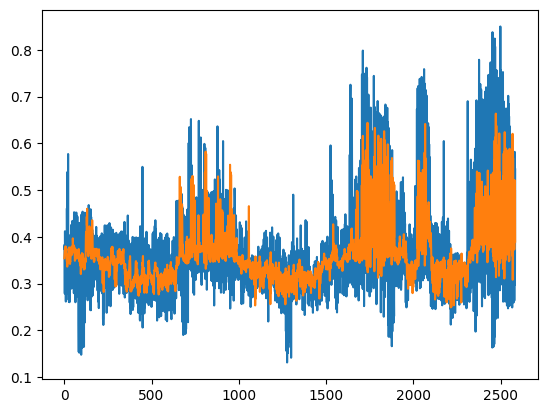

In [ ]:
gru_result = plot_predictions(gru_model, X_test, y_test, tstart=0, tend=8000)

In [129]:
df_cm_denorm = denormalize(gru_result)
df_cm_denorm

,CPU Predictions,CPU Actuals
0,43.675842,46.133333
1,44.153008,45.400000
2,44.387417,45.850000
3,45.147274,36.888889
4,45.560596,48.866667
...,...,...
2580,58.709488,38.690476
2581,53.102489,64.133333
2582,46.780590,38.566667
2583,56.775330,41.714286


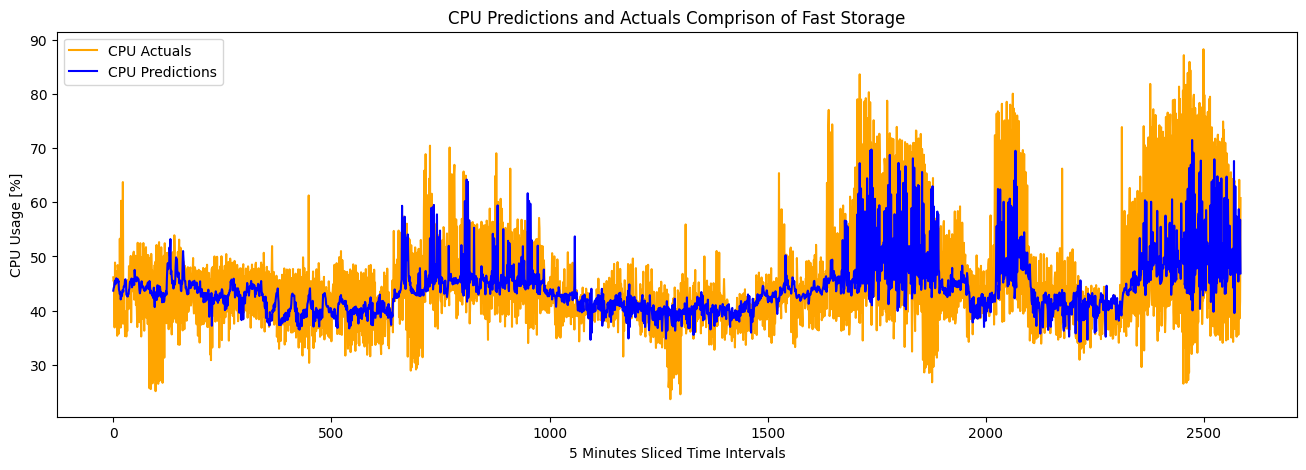

In [133]:
plt.figure(figsize=(16,5))
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Actuals'], label='CPU Actuals', color='orange')
plt.plot(df_cm_denorm.index, df_cm_denorm['CPU Predictions'], label='CPU Predictions', color='blue')
plt.xlabel('5 Minutes Sliced Time Intervals')
plt.ylabel('CPU Usage [%]')
plt.title('CPU Predictions and Actuals Comprison of Fast Storage')
plt.legend()

In [131]:
# Evaluate the model
mse = mean_squared_error(df_cm_denorm['CPU Predictions'], df_cm_denorm['CPU Actuals'])
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 8.979553845918657


In [134]:
gru_model.save('model0/gru_temp.keras')

In [7]:
lstm_model = load_model('model0/lstm_352600_trained_v4.keras')

In [8]:
# Save the model to a file
with open('model0/xbgr_v4.pkl', 'wb') as file:
    lstm_model.dump(best_model, file)

AttributeError: 'Sequential' object has no attribute 'dump'

# Inference

In [21]:
# Load the model architecture from JSON
with open("model0/bi_lstm/bi_lstm352600_v4.json", "r") as json_file:
    loaded_model_json = json_file.read()
bi_model = model_from_json(loaded_model_json)

# Load the weights into the new model
bi_model_load.load_weights("model0/bi_lstm/bi_lstm352600_v4.weights.h5")

# Compile the model
bi_model.compile(optimizer=Adam(learning_rate=0.001), 
                 loss=MeanSquaredError(), 
                 metrics=[RootMeanSquaredError()])

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 72, 7], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [29]:
#bimodel_load = load_model('model0/bilstm_test_synth.keras')
lstmmodel_load = load_model('models/lstm.keras')

In [30]:
def calculate_rmse(predictions, actuals):
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

def calculate_mae(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    return mae

def denormalize(predictions, actuals, c_max, c_min):
    denorm_predictions = predictions * (c_max - c_min) + c_min
    denorm_actuals = actuals * (c_max - c_min) + c_min
    return denorm_predictions, denorm_actuals

def plot_predictions(model, X, y, c_max, c_min, tstart=0, tend=500):
    predictions = model.predict(X)
    # Initialize an empty list to store RMSE values for each sequence
    rmse_values = []
    mae_values = []
    denorm_rmse_values = []
    denorm_mae_values = []
    
    for i in range(predictions.shape[0]):
        
        seq_pred = predictions[i]
        seq_actual = y[i]

        # De-normalize the predictions and actuals
        denorm_pred, denorm_actual = denormalize(seq_pred, seq_actual, c_max, c_min)
        
        # Calculate RMSE for de-normalized data
        denorm_rmse = calculate_rmse(denorm_pred, denorm_actual)
        denorm_rmse_values.append(denorm_rmse)

        denorm_mae = calculate_mae(denorm_pred, denorm_actual)
        denorm_mae_values.append(denorm_mae)
    
    print(predictions[0])
    # Calculate overall RMSE
    #overall_rmse = np.mean(rmse_values)
    overall_denorm_rmse = np.mean(denorm_rmse_values)
    overall_denorm_mae = np.mean(denorm_mae_values)
    
    # Create a DataFrame for plotting purposes
    # this following set is flattening the predictions and concatenating it. Means (2585,6) flatten is 15510
    # test_results_flatten_norm = pd.DataFrame({
    #     'CPU Predictions': predictions.flatten(),
    #     'CPU Actuals': y.flatten()
    # })

    # test_results_norm = pd.DataFrame({
    #     'CPU Predictions': predictions[:, 0],
    #     'CPU Actuals': y[:,0]
    # })

    dfnorm_pred_all, denorm_actuall_all = denormalize(predictions[:, 0], y[:,0], c_max, c_min)

    test_results_non_norm = pd.DataFrame({
        'CPU Predictions': dfnorm_pred_all,
        'CPU Actuals': denorm_actuall_all
    })
    
    return test_results_non_norm[tstart:tend], denorm_rmse_values, overall_denorm_rmse, denorm_mae_values, overall_denorm_mae

In [31]:
c_max = df['CPU usage [%]'].max()
c_min = df['CPU usage [%]'].min()

test_results_lstm, rmse_values_lstm, avg_rmse_lstm, mae_values_lstm, avg_mae_lstm = plot_predictions(lstmmodel_load, X_test, y_test, c_max, c_min, tstart=0, tend=15000)

81/81 [==============================] - 6s 67ms/step
[ 0.48214126 -0.03358273  0.33155254  0.45519596 -0.00180293  0.3434078
  0.44716567 -0.01385217  0.3310431   0.482351   -0.00267611  0.35154006
  0.45808145 -0.00360725  0.34050348  0.45662677 -0.01346946  0.33058473]


In [32]:
c_max = df['CPU usage [%]'].max()
c_min = df['CPU usage [%]'].min()

test_results, rmse_values, avg_rmse, mae_values, avg_mae = plot_predictions(bimodel_load, X_test, y_test, c_max, c_min, tstart=0, tend=15000)

# Identify the condition where 'CPU Predictions' is greater than 100 or less than 0
condition = (test_results['CPU Predictions'] > 100) | (test_results['CPU Predictions'] < 0)

# Set values greater than 100 or less than 0 to NaN
test_results.loc[condition, 'CPU Predictions'] = None

# Forward fill the NaN values
test_results['CPU Predictions'] = test_results['CPU Predictions'].ffill()

189/189 [==============================] - 4s 22ms/step
[0.5059055  0.36974367 0.28670698 0.50202304 0.38562047 0.3055879
 0.5116945  0.37677485 0.283716   0.49162593 0.38725713 0.2839776
 0.5059222  0.3933818  0.29385588 0.50853866 0.37720174 0.29657894]


In [33]:
avg_rmse_lstm, avg_mae_lstm

(9.275220591880961, 7.037766178235017)

In [34]:
lstm_rmse = calculate_rmse(test_results_lstm['CPU Actuals'], test_results_lstm['CPU Predictions'])
lstm_mae = calculate_mae(test_results_lstm['CPU Actuals'], test_results_lstm['CPU Predictions'])
#bi_rmse = calculate_rmse(test_results['CPU Actuals'], test_results['CPU Predictions'])
#bi_mae = calculate_mae(test_results['CPU Actuals'], test_results['CPU Predictions'])

lstm_rmse, lstm_mae 

(8.520127501033892, 6.103390731739627)

In [35]:
bi_rmse, bi_mae

(7.108913200799762, 5.535787273768379)

In [35]:
filtered_bi = test_results.iloc[840:2571]
filtered_lstm = test_results_lstm[840:2571]

NameError: name 'test_results' is not defined

In [58]:
filtered_lstm.head(12)

,CPU Predictions,CPU Actuals
840,63.186852,66.200000
841,46.762928,42.150000
842,39.453995,40.288889
843,64.630981,79.000000
844,46.732506,47.083333
845,39.872276,40.155556
846,67.182640,83.600000
847,47.371048,37.833333
848,40.368713,45.722222
849,69.224037,78.966667


In [52]:
filtered_bi.to_pickle('model0/bilstm.pkl')
filtered_lstm.to_pickle('model0/lstm.pkl')
# df4.to_pickle('model0/gtf4.pkl')
# df6.to_pickle('model0/gtf6.pkl')

In [37]:
test_results_lstm

,CPU Predictions,CPU Actuals
0,51.699833,47.533333
1,-1.937244,2.250000
2,36.423691,29.633333
3,53.004322,53.266667
4,-1.713740,2.250000
...,...,...
2557,3.533073,6.500000
2558,19.204765,14.733333
2559,74.897499,63.966667
2560,4.759590,6.533333


Text(0.5, 0, 'Testing Data ')

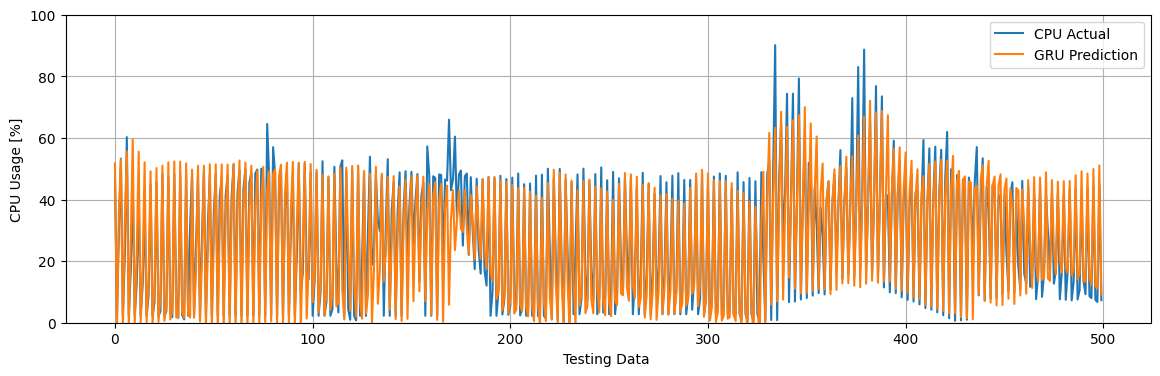

In [40]:
plt.figure(figsize=(14,4))
plt.plot(test_results_lstm.index[:500], test_results_lstm['CPU Actuals'][:500], label='CPU Actual')
plt.plot(test_results_lstm.index[:500], test_results_lstm['CPU Predictions'][:500], label='GRU Prediction')
#plt.plot(test_results_lstm.index, test_results_lstm['CPU Predictions'], label='LSTM Predictions')
#plt.plot(denorm_result_bi.index, denorm_result_bi['CPU Predictions'], label='Bi-LSTM Predictions')
#plt.plot(df_xgbr.index, df_xgbr['CPU Predictions'], label='XGBR Predictions')
#plt.title('Non-Normalized')
plt.grid()
plt.ylim([0,100])
plt.ylabel('CPU Usage [%]')
#ax2.text(0.02, 0.9, f'RMSE: {overall_denorm_rmse:.4f}', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
plt.legend()
#plt.savefig('models_predictions_full_TestingData.pdf', format='pdf')
plt.xlabel('Testing Data ')

In [30]:
inf_time_bi = []
for i in range(1000):
    b_time = time.time()
    instance = X_test[i]
    instance_reshape = instance.reshape(1, instance.shape[0], instance.shape[1])
    bimodel_load.predict(instance_reshape)
    single_inftime = time.time() - b_time
    inf_time_bi.append(single_inftime) 

inf_time_lstm = []
for i in range(1000):
    b_time = time.time()
    instance = X_test[i]
    instance_reshape = instance.reshape(1, instance.shape[0], instance.shape[1])
    lstmmodel_load.predict(instance_reshape)
    single_inftime = time.time() - b_time
    inf_time_lstm.append(single_inftime) 

1/1 [==============================] - 0s 22ms/step


In [31]:
mili_inf_bi = [x * 1000 for x in inf_time_bi]
mean_infer_bi = sum(mili_inf_bi) / len(mili_inf_bi)


mili_inf_lstm = [x * 1000 for x in inf_time_lstm]
mean_infer_lstm = sum(mili_inf_lstm) / len(mili_inf_lstm)
mean_infer_bi, mean_infer_lstm

(47.48353958129883, 49.31189966201782)